<a href="https://colab.research.google.com/github/Code-Trees/Cifar10/blob/main/Cifar10_Model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
%autosave 5

Autosaving every 5 seconds


In [3]:
# !pip -q install opencv-python
# !pip -q install -U albumentations
# !pip -q  install opencv-python-headless==4.5.2.52
# !pip -q  install Pillow
# !pip -q  install rf_calc
# !pip -q install torch-lr-finder

In [4]:
def module_refresh():
    import os
    if 'strixbee' in os.listdir():
        os.system("rm -rf strixbee")
        !git clone https://github.com/Code-Trees/strixbee.git
    else:
        !git clone https://github.com/Code-Trees/strixbee.git

In [5]:
# module_refresh()

In [6]:
try:
    #main.py
    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import torch
    import torch.nn.functional as F
    import torch.nn as nn

    from torch.optim import SGD
    from torch.utils.data import DataLoader
    from torch.utils.data.dataset import Dataset
    from torch.optim.lr_scheduler import StepLR

    from torchvision import transforms,datasets

    import numpy as np
    import matplotlib.pyplot as plt
    from torchsummary import summary
    import random
    import seaborn as sns
    import gc

    import albumentations as A
    from albumentations.augmentations.geometric.resize import Resize
    from albumentations.pytorch.transforms import ToTensorV2

    from rf_calc import receptive_field
    import seaborn as sns
    import matplotlib.pyplot as plt
except:
    !pip -q install opencv-python
    !pip -q install -U albumentations
    !pip -q  install opencv-python-headless==4.5.2.52
    !pip -q  install Pillow
    !pip -q  install rf_calc
    !pip -q install torch-lr-finder

    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import torch
    import torch.nn.functional as F
    import torch.nn as nn

    from torch.optim import SGD
    from torch.utils.data import DataLoader
    from torch.utils.data.dataset import Dataset
    from torch.optim.lr_scheduler import StepLR

    from torchvision import transforms,datasets

    import numpy as np
    import matplotlib.pyplot as plt
    from torchsummary import summary
    import random
    import seaborn as sns
    import gc

    import albumentations as A
    from albumentations.augmentations.geometric.resize import Resize
    from albumentations.pytorch.transforms import ToTensorV2

    from rf_calc import receptive_field
    import seaborn as sns
    import matplotlib.pyplot as plt

In [7]:
from strixbee.utils.data_iter import get_data,get_data_stats
from strixbee.utils.data_transforms import AlbumDataset
from strixbee.utils.optimizer_utils import *
from strixbee.utils.train_test import *
from strixbee.utils.gpu import clean_gpu
from strixbee.utils.plots import * 
from strixbee.utils import *
from strixbee.model.custom_layer import *

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified
Train Shape: (50000, 32, 32, 3) Test Shape: (10000, 32, 32, 3) 



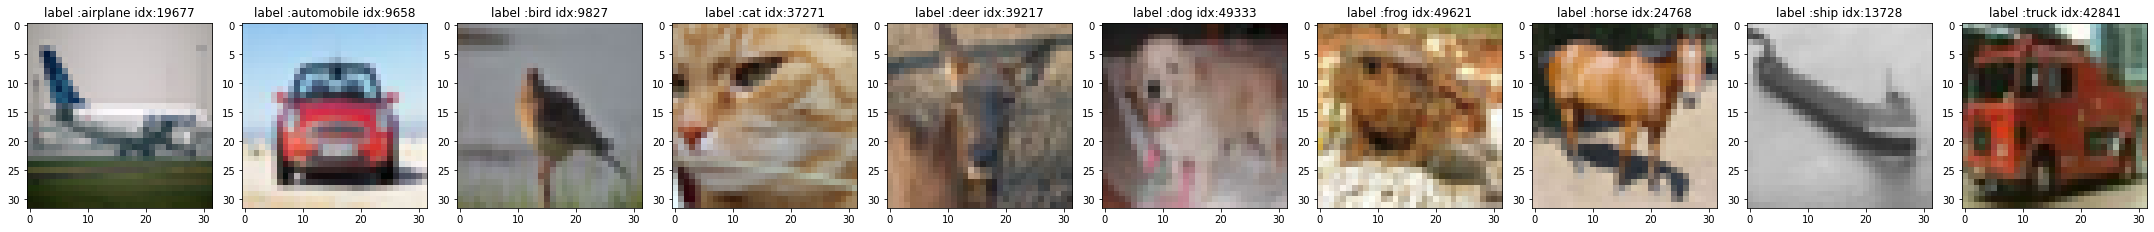

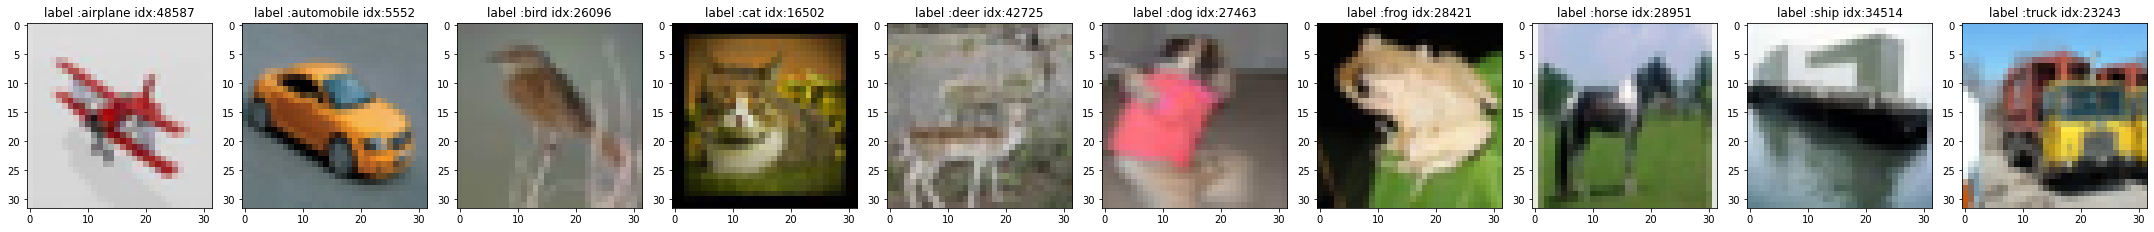

In [8]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
train,test = get_data()
print(f"Train Shape: {train.data.shape} Test Shape: {test.data.shape} \n")
plot_unique_images(train,labels =labels)
plot_unique_images(train,labels =labels)

In [9]:
mean,std  = get_data_stats(train,test,img_norm_typ ='train',plot = False)
print(f"Mean :{mean} , Std :{std}")

Mean :(0.49139967861519745, 0.4821584083946076, 0.44653091444546616) , Std :(0.2470322324632823, 0.24348512800005553, 0.2615878417279641)


<Figure size 1080x360 with 0 Axes>

In [10]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [11]:
#model1
class Cifar10Net1(nn.Module):
    def __init__(self,dropout_val = 0,norm_type = 'bn'):
        super(Cifar10Net1,self).__init__()
        self.norm_type = norm_type
        self.drop = dropout_val

        self.block1 = nn.Sequential(
            ConvBlock(in_channels=3,out_channels=16,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=16,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop)
            )
        
        # self.pool1 =nn.MaxPool2d(kernel_size=(2,2),stride = 2)
        self.pool1 =ConvBlock(in_channels=32,out_channels =32,kernel_size = (3,3),stride = 2,padding = 1)


        self.block2 = nn.Sequential(
            ConvBlock(in_channels=32,out_channels=16,kernel_size = (1,1),stride = 1, padding = 0,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=16,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),

            # ConvBlock(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            )

        # self.pool2 = nn.MaxPool2d(kernel_size = (2,2),stride  = 2)
        self.pool2 =ConvBlock(in_channels=64,out_channels =64,kernel_size = (3,3),stride = 2,padding = 1)


        self.block3 = nn.Sequential(
            ConvBlock(in_channels=64,out_channels=16,kernel_size = (1,1),stride = 1, padding = 0,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=16,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            )

        # self.pool3 = nn.MaxPool2d(kernel_size = (2,2),stride  = 2)
        self.pool3 =ConvBlock(in_channels=64,out_channels =64,kernel_size = (3,3),stride = 2,padding = 1)


        self.block4 = nn.Sequential(
            ConvBlock(in_channels=64,out_channels=16,kernel_size = (1,1),stride = 1, padding = 0,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=16,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            )
        self.pool4 = nn.MaxPool2d(kernel_size = (2,2),stride  = 2)
        self.pool4 =ConvBlock(in_channels=64,out_channels =64,kernel_size = (3,3),stride = 2,padding = 1)

        self.GAP = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.con1 = nn.Conv2d(in_channels = 64,out_channels = 10,kernel_size = (3,3),padding = 1,stride = 1)
        self.con2 = nn.Conv2d(in_channels = 10,out_channels = 10,kernel_size = (1,1))
        

    def forward(self,x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = self.block3(x)
        x = self.pool3(x)
        x = self.block4(x)
        x = self.pool4(x)
        x = self.GAP(x)
        x = self.con1(x)
        x = self.con2(x)
        x = x.view(-1,10)
        # return x
        return F.log_softmax(x,dim = -1)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_demo =Cifar10Net1(dropout_val = 0.01,norm_type = 'bn').to(device)
summary(model_demo,(3,32,32))
df = receptive_field(model_demo,32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
         ConvBlock-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           4,608
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
         Dropout2d-9           [-1, 32, 32, 32]               0
        ConvBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        Dropout2d-14           [-1, 32,

In [13]:
def Run_Model(model_class,train_loader,test_loader,epochs , L1 = False):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print (f'running on {device} \n')
    #take input as normal_type ['gbn','bn','gn','ln']
    model = model_class.to(device)
    try:
        # print(summary(model,input_size = (3,32,32)))
        pass
    except:
        pass

    # optimizer,scheduler = get_optimizer(model,lr =0.01,scheduler = True,scheduler_type = 'steplr')
    # optimizer,scheduler = get_optimizer(model,lr =0.01,scheduler = True,scheduler_type = 'reducelronplateau')
    optimizer = get_optimizer(model,lr =0.01,scheduler = False,scheduler_type = None)
    # optimizer,scheduler = get_optimizer(model,scheduler = True )
    # optimizer = SGD( params = model.parameters(),lr = 0.01,momentum = 0.9)
    # scheduler = StepLR(optimizer,step_size = 20,gamma = 0.1)

    train_losses = []
    train_accuracy = []
    test_losses =[]
    test_accuracy = []

    for EPOCHS in range(0,epochs):
        if L1 == True:
            train_loss, train_acc = trainning(model,device,train_loader,optimizer,EPOCHS,L1 = L1)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)
        else:
            train_loss, train_acc = trainning(model,device,train_loader,optimizer,EPOCHS)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)

        test_loss,test_acc = testing(model,device,test_loader,optimizer,EPOCHS)

        test_accuracy.append(test_acc)
        test_losses.append(test_loss)
        
        # scheduler.step()
        # scheduler.step(train_loss)
        
        try:
            if (EPOCHS >=3)&(max(test_accuracy[:-1]) < test_accuracy[-1]) & (max(test_accuracy) >= .85):
                checkpoint = {'epoch': EPOCHS + 1,'valid_loss_min': test_losses[-1],'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),} # Export to TorchScript
                torch.save(checkpoint ,'./Model_cifar10.pt') # Save
                print (f" Target Achieved: {max(test_accuracy)*100}% Test Accuracy !!")
        except:
            print('Model Saving Failed !!')

        # print ("LR :{}\n".format(scheduler.get_lr()[0]))
    return model,train_losses, train_accuracy,test_losses,test_accuracy


Files already downloaded and verified
Files already downloaded and verified
running on cuda 



Train ==> Epochs: 0 Batch:  781 loss: 1.9922164678573608 Accuracy: 23.16% : 100%|██████████| 782/782 [00:13<00:00, 55.92it/s]
Test ==> Epochs: 0 Batch:  156 loss: 0.02643804874420166 Accuracy: 37.20% : 100%|██████████| 157/157 [00:01<00:00, 94.48it/s] 


Model Saving Failed !!


Train ==> Epochs: 1 Batch:  781 loss: 1.3228768110275269 Accuracy: 33.13% : 100%|██████████| 782/782 [00:14<00:00, 54.40it/s]
Test ==> Epochs: 1 Batch:  156 loss: 0.02446059342622757 Accuracy: 41.33% : 100%|██████████| 157/157 [00:01<00:00, 93.29it/s] 
Train ==> Epochs: 2 Batch:  781 loss: 1.5336130857467651 Accuracy: 36.72% : 100%|██████████| 782/782 [00:14<00:00, 55.77it/s]
Test ==> Epochs: 2 Batch:  156 loss: 0.0226004167675972 Accuracy: 45.77% : 100%|██████████| 157/157 [00:01<00:00, 92.91it/s] 
Train ==> Epochs: 3 Batch:  781 loss: 1.7436935901641846 Accuracy: 39.28% : 100%|██████████| 782/782 [00:14<00:00, 54.10it/s]
Test ==> Epochs: 3 Batch:  156 loss: 0.02204352880716324 Accuracy: 48.04% : 100%|██████████| 157/157 [00:01<00:00, 92.20it/s] 
Train ==> Epochs: 4 Batch:  781 loss: 1.8098968267440796 Accuracy: 40.88% : 100%|██████████| 782/782 [00:15<00:00, 51.99it/s]
Test ==> Epochs: 4 Batch:  156 loss: 0.021662131428718565 Accuracy: 49.18% : 100%|██████████| 157/157 [00:01<00:00, 

<Figure size 1080x360 with 0 Axes>

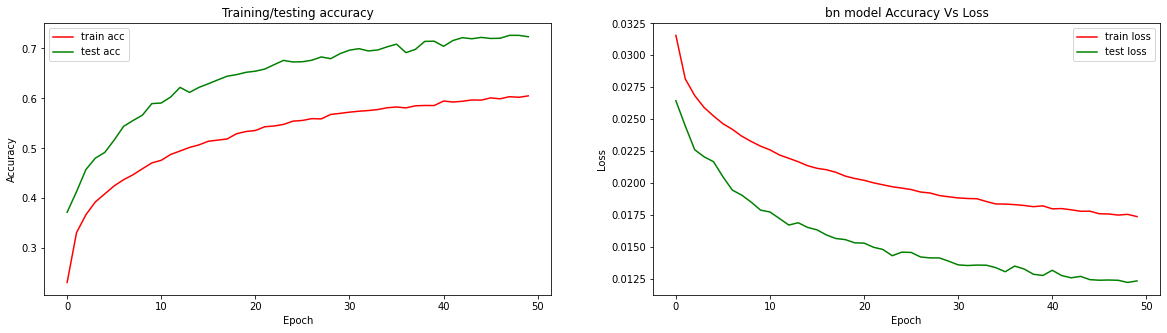

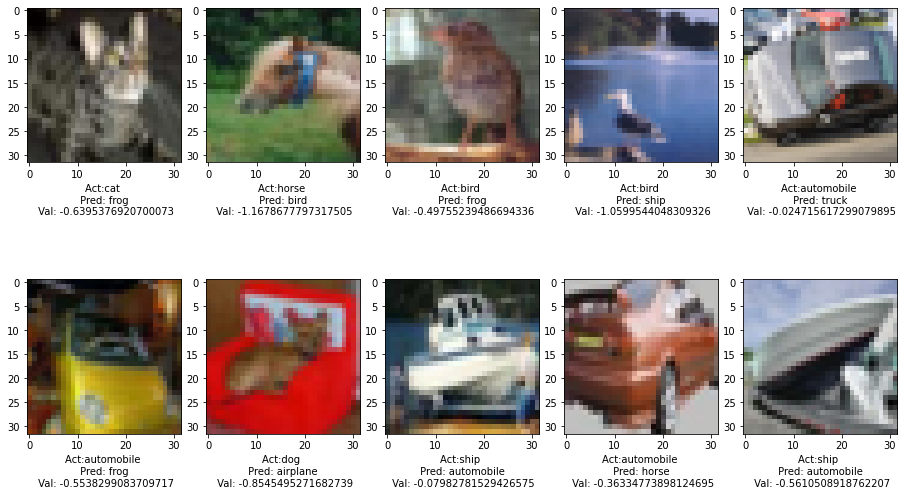

In [14]:
if __name__ == "__main__":
    batch_size = 64
    epochs = 50

    _=torch.manual_seed(1)
    if torch.cuda.is_available():
        _=torch.cuda.manual_seed(1)

    train,test = get_data()
    #take input as normal_type ['gbn','bn','gn','ln']
    # To Un Normalize the test data
    mean,std  = get_data_stats(test,train,img_norm_typ ='train',plot = False)
    
    # # Advanced Normalization
    train_transform =A.Compose([A.Resize(32,32),
                                A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                                 A.ShiftScaleRotate(always_apply=False),
                                 A.CoarseDropout(always_apply = False,max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=mean, mask_fill_value = None),
                                ToTensorV2(transpose_mask =False),
                                 ])      
    test_transform = A.Compose([A.Resize(32,32),
                                 A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                               ToTensorV2(transpose_mask =False), ])
    # #basic Normalization
    # train_transform =A.Compose([A.Resize(32,32),
    #                             A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
    #                             ToTensorV2(transpose_mask =False),
    #                             ])      
    # test_transform = A.Compose([A.Resize(32,32),
    #                             A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
    #                             ToTensorV2(transpose_mask =False,),
    #                             ])

    train_alb = AlbumDataset(train,train_transform)
    test_alb = AlbumDataset(test,test_transform)

    args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train_alb,batch_size=batch_size,shuffle = True,**args)
    test_loader = DataLoader(test_alb,batch_size=batch_size,**args)
    # ['gbn','bn','gn','ln']
    try_type = ['bn']
    for norm_type in try_type:

        model_class =Cifar10Net1(dropout_val = 0.1,norm_type = norm_type)
        
        # model_class = model
        model,train_losses, train_accuracy,test_losses,test_accuracy = Run_Model(model_class,train_loader,test_loader,epochs =epochs)

        plot_acc_loss(norm_type ,train_accuracy,train_losses,test_accuracy,test_losses)
        clean_gpu()

        print_wrong_image(model,test_loader,mean,std,2,5)
        clean_gpu()

In [15]:
# #model Designing 

# model = Cifar10Net1(dropout_val = 0.00,norm_type = norm_type)
# model = model.to(device)

# model.train()

# train_loader 
# for index_id,(data,target) in enumerate(train_loader):
#     data,target = data.to(device),target.to(device)
#     # optimizer.zero_grad()
#     output = model(data)
#     break
# output.shape